In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 27.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
# Import Dataset
df = pd.read_excel('/content/drive/MyDrive/invisalignKeyword_raw.xlsx')
#print(df.target_names.unique())
df.head()

,SubmissionNumber,Content
0,1,Did any of you ever get used to the feeling of...
1,2,Started with metal braces and after a month of...
2,3,Invisalign vs ceramic braces... Which would yo...
3,4,How long do you leave your braces off to eat?I...
4,5,Im only wearing my Invisalign 10-14hrs a day. ...


In [11]:
# Convert to list
data = df.Content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Did any of you ever get used to the feeling of the trays in your mouth, I '
 'never did throughout the entire process, I was uncomfortable and missed my '
 'braces.']


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['did', 'any', 'of', 'you', 'ever', 'get', 'used', 'to', 'the', 'feeling', 'of', 'the', 'trays', 'in', 'your', 'mouth', 'never', 'did', 'throughout', 'the', 'entire', 'process', 'was', 'uncomfortable', 'and', 'missed', 'my', 'braces']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['did', 'any', 'of', 'you', 'ever', 'get', 'used', 'to', 'the', 'feeling', 'of', 'the', 'trays', 'in', 'your', 'mouth', 'never', 'did', 'throughout', 'the', 'entire', 'process', 'was', 'uncomfortable', 'and', 'missed', 'my', 'braces']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ever', 'get', 'use', 'feeling', 'tray', 'mouth', 'never', 'entire', 'process', 'uncomfortable', 'miss', 'brace']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('brace', 1),
  ('entire', 1),
  ('ever', 1),
  ('feeling', 1),
  ('get', 1),
  ('miss', 1),
  ('mouth', 1),
  ('never', 1),
  ('process', 1),
  ('tray', 1),
  ('uncomfortable', 1),
  ('use', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.092*"fine" + 0.066*"advice" + 0.058*"yet" + 0.055*"jaw" + 0.053*"option" '
  '+ 0.039*"less" + 0.035*"easy" + 0.031*"line" + 0.026*"shape" + '
  '0.021*"vacation"'),
 (1,
  '0.075*"extra" + 0.033*"half" + 0.030*"opt" + 0.013*"consider" + '
  '0.004*"invisalignha" + 0.004*"deep" + 0.003*"fee" + 0.000*"price" + '
  '0.000*"mention" + 0.000*"grind"'),
 (2,
  '0.060*"canine" + 0.043*"pull" + 0.042*"sore" + 0.039*"cheap" + '
  '0.037*"perfect" + 0.030*"expensive" + 0.025*"difficult" + 0.023*"mention" + '
  '0.021*"view" + 0.019*"quality"'),
 (3,
  '0.049*"attachment" + 0.039*"hear" + 0.035*"come" + 0.034*"bottom" + '
  '0.034*"tooth" + 0.029*"way" + 0.027*"pay" + 0.026*"plan" + 0.025*"tell" + '
  '0.023*"smile"'),
 (4,
  '0.071*"tooth" + 0.028*"get" + 0.022*"pain" + 0.022*"year" + 0.022*"bite" + '
  '0.021*"still" + 0.020*"front" + 0.019*"normal" + 0.019*"look" + '
  '0.019*"fix"'),
 (5,
  '0.063*"correct" + 0.051*"lip" + 0.041*"face" + 0.039*"second" + '
  '0.037*"progress" + 0.0

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.145769947038842

Coherence Score:  0.4115190268007975


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.351670  0.024783       1        1  29.125090
12     0.367663  0.062936       2        1  27.340661
4      0.314606 -0.117653       3        1  18.712802
3      0.191112 -0.182341       4        1   5.589672
11     0.131765  0.276790       5        1   4.666516
5     -0.003468 -0.067541       6        1   2.819983
10    -0.062767  0.088822       7        1   2.438780
6     -0.077841  0.006372       8        1   1.536490
2     -0.096834 -0.016143       9        1   1.446618
0     -0.095509 -0.013332      10        1   1.371237
14    -0.087763  0.032668      11        1   1.084716
16    -0.089473 -0.015243      12        1   0.921135
17    -0.105371 -0.026526      13        1   0.581041
9     -0.111316 -0.002291      14        1   0.579894
7     -0.093239 -0.035191      15        1   0.535916
13    -0.108273 -0.005607      16        1   0.525161
19    -0.109693 -0.006558      17        1   0.426429
1     -0.107362  0.008227      18        1   0.173874
15    -0.103933 -0.006064      19        1   0.067065
8     -0.103974 -0.006109      20        1   0.056919, topic_info=           Term        Freq       Total Category  logprob  loglift
14   invisalign  723.000000  723.000000  Default  30.0000  30.0000
9          tray  347.000000  347.000000  Default  29.0000  29.0000
85         wear   78.000000   78.000000  Default  28.0000  28.0000
6         mouth   69.000000   69.000000  Default  27.0000  27.0000
190    retainer   48.000000   48.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
235       worry    0.003851   12.491349  Topic20  -7.7266  -0.6133
0         brace    0.003851  250.658076  Topic20  -7.7266  -3.6123
59          day    0.003851  138.229036  Topic20  -7.7266  -3.0171
76         time    0.003851  127.428169  Topic20  -7.7266  -2.9358
233          ve    0.003851  128.026100  Topic20  -7.7266  -2.9404

[902 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
398       2  0.969084  absolutely
736      11  0.777885    activity
123       1  0.374538    actually
123       5  0.582614    actually
672       3  0.982048      adjust
...     ...       ...         ...
147       3  0.580370        year
162       1  0.926795   yesterday
283      10  0.933901         yet
122       7  0.278646       young
122      16  0.557291       young

[715 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 13, 5, 4, 12, 6, 11, 7, 3, 1, 15, 17, 18, 10, 8, 14, 20, 2, 16, 9])

In [25]:
def compute_coherence_values(dictionary,corpus,texts,start,limit,step):
    coherence_vals=[]
    model_list=[]
    
    for num_topics in range(start,limit,step):
        # building LDA Model
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,
                                              num_topics=num_topics,random_state=100,
                                              chunksize=100,passes=10,alpha='auto',per_word_topics=True)

        model_list.append(model)
        
        coherencemodel=CoherenceModel(model=model,texts=texts,dictionary=dictionary,coherence='c_v')
        
        coherence_vals.append(coherencemodel.get_coherence())
    return model_list,coherence_vals

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=4)

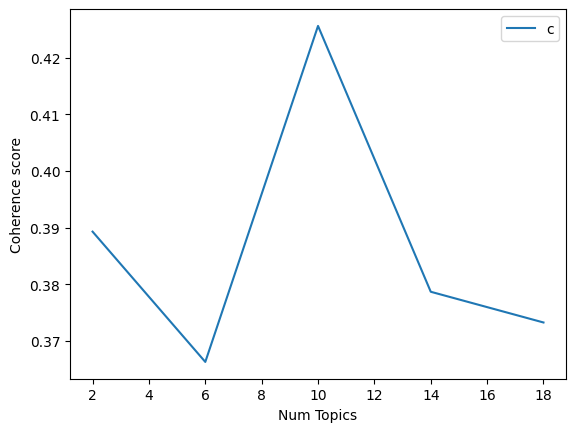

In [32]:
# Show graph
limit=20; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3893
Num Topics = 6  has Coherence Value of 0.3663
Num Topics = 10  has Coherence Value of 0.4256
Num Topics = 14  has Coherence Value of 0.3787
Num Topics = 18  has Coherence Value of 0.3733


In [34]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"tray" + 0.028*"day" + 0.023*"get" + 0.019*"eat" + 0.018*"take" + '
  '0.015*"pain" + 0.015*"first" + 0.014*"invisalign" + 0.013*"m" + '
  '0.012*"aligner"'),
 (1,
  '0.027*"progress" + 0.024*"quite" + 0.016*"pic" + 0.013*"comfortable" + '
  '0.013*"extra" + 0.012*"tray" + 0.011*"break" + 0.011*"tip" + 0.010*"depend" '
  '+ 0.010*"movement"'),
 (2,
  '0.027*"mouth" + 0.024*"drink" + 0.015*"tooth" + 0.015*"weird" + '
  '0.014*"feel" + 0.014*"chew" + 0.011*"tiny" + 0.010*"good" + 0.009*"monster" '
  '+ 0.008*"include"'),
 (3,
  '0.041*"invisalign" + 0.019*"say" + 0.015*"attachment" + 0.014*"people" + '
  '0.013*"m" + 0.013*"know" + 0.013*"s" + 0.013*"go" + 0.012*"get" + '
  '0.012*"take"'),
 (4,
  '0.060*"tooth" + 0.056*"invisalign" + 0.027*"get" + 0.027*"brace" + '
  '0.026*"m" + 0.016*"year" + 0.013*"week" + 0.013*"tray" + 0.012*"go" + '
  '0.012*"treatment"'),
 (5,
  '0.019*"tooth" + 0.015*"move" + 0.015*"invisalign" + 0.014*"back" + '
  '0.014*"end" + 0.012*"tray" + 0.0

In [36]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

<ipython-input-36-665470177464>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-36-665470177464>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.4585,"mouth, drink, tooth, weird, feel, chew, tiny, ...",Did any of you ever get used to the feeling of...
1,1,4,0.7209,"tooth, invisalign, get, brace, m, year, week, ...",Started with metal braces and after a month of...
2,2,3,0.5586,"invisalign, say, attachment, people, m, know, ...",Invisalign vs ceramic braces... Which would yo...
3,3,0,0.3747,"tray, day, get, eat, take, pain, first, invisa...",How long do you leave your braces off to eat?I...
4,4,4,0.7582,"tooth, invisalign, get, brace, m, year, week, ...",Im only wearing my Invisalign 10-14hrs a day. ...
5,5,4,0.5066,"tooth, invisalign, get, brace, m, year, week, ...",Starting Invisalign as an Adult who Never had ...
6,6,4,0.6973,"tooth, invisalign, get, brace, m, year, week, ...",Should I get braces?
7,7,4,0.5687,"tooth, invisalign, get, brace, m, year, week, ...",Braces v Invisalign (two different answers fro...
8,8,4,0.6956,"tooth, invisalign, get, brace, m, year, week, ...",INVISALIGN OR BRACES??
9,9,4,0.9206,"tooth, invisalign, get, brace, m, year, week, ...",5 months & 14 trays - done with Invisalign! I ...


In [37]:
df_dominant_topic.to_excel('TM_genism_classification.xlsx',index=False)

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.8741,"tray, day, get, eat, take, pain, first, invisa...",Invisalign is NOT that badThis is for the peop...
1,1,0.6188,"progress, quite, pic, comfortable, extra, tray...",Invisalign retainer broke and I swallowed a fe...
2,2,0.6967,"mouth, drink, tooth, weird, feel, chew, tiny, ...","Yall, I feel like I have FORGOTTEN HOW TO CHEW..."
3,3,0.9501,"invisalign, say, attachment, people, m, know, ...",Invisalign vs Braces for backpacking and bike ...
4,4,0.9877,"tooth, invisalign, get, brace, m, year, week, ...",Question about braces to retainers then to inv...


In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2,"mouth, drink, tooth, weird, feel, chew, tiny, ...",74.0,0.1605
1,4,"tooth, invisalign, get, brace, m, year, week, ...",4.0,0.0087
2,3,"invisalign, say, attachment, people, m, know, ...",19.0,0.0412
3,0,"tray, day, get, eat, take, pain, first, invisa...",82.0,0.1779
4,4,"tooth, invisalign, get, brace, m, year, week, ...",227.0,0.4924
...,...,...,...,...
456,4,"tooth, invisalign, get, brace, m, year, week, ...",NaN,NaN
457,0,"tray, day, get, eat, take, pain, first, invisa...",NaN,NaN
458,0,"tray, day, get, eat, take, pain, first, invisa...",NaN,NaN
459,0,"tray, day, get, eat, take, pain, first, invisa...",NaN,NaN


In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/